In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import yt
import numpy as np
import os
from astropy import units as u
import cv2 as cv

# Reading data and define volume box

In [67]:
# read the lowest boundary mask and the highest boundary mask
timestamp = 200
lowest_z = 0
highest_z = 600


lowest_file = f'/home/joy0921/Desktop/2023S/Dataset/200_210/mask_outputs/{timestamp}/sn34_smd132_bx5_pe300_hdf5_plt_cnt_0{timestamp}_z{lowest_z}/metadata.csv'
highest_file = f'/home/joy0921/Desktop/2023S/Dataset/200_210/mask_outputs/{timestamp}/sn34_smd132_bx5_pe300_hdf5_plt_cnt_0{timestamp}_z{highest_z}/metadata.csv'


# define the volums cube (read the coordinate)

low_x0, low_y0, low_w, low_h = 386,456, 350, 343
# high: 502 646 216 153


In [3]:
# CV lab
datadir = "/home/joy0921/Desktop/2023S/Dataset/200_360/finer_time_200_360_original"

# Compute2
# datadir = '/home/joy0921/Desktop/Dataset/200_210/raw_data'

filename = "sn34_smd132_bx5_pe300_hdf5_plt_cnt_0200"

ds = yt.load(os.path.join(datadir, filename))

yt : [INFO     ] 2023-12-18 13:50:56,875 Parameters: current_time              = 6027503856450000.0
yt : [INFO     ] 2023-12-18 13:50:56,876 Parameters: domain_dimensions         = [  32   32 1280]
yt : [INFO     ] 2023-12-18 13:50:56,877 Parameters: domain_left_edge          = [-1.54283879e+21 -1.54283879e+21 -6.17135516e+22]
yt : [INFO     ] 2023-12-18 13:50:56,879 Parameters: domain_right_edge         = [1.54283879e+21 1.54283879e+21 6.17135516e+22]
yt : [INFO     ] 2023-12-18 13:50:56,879 Parameters: cosmological_simulation   = 0


In [4]:
ad = ds.all_data()

center =  [0, 0, 0]*yt.units.pc
arb_center = ds.arr(center,'code_length')
left_edge = arb_center - ds.quan(500,'pc')
right_edge = arb_center + ds.quan(500,'pc')

obj = ds.arbitrary_grid(left_edge, right_edge, dims=[800,800,800])
print(obj["flash", "dens"].shape)

(800, 800, 800)


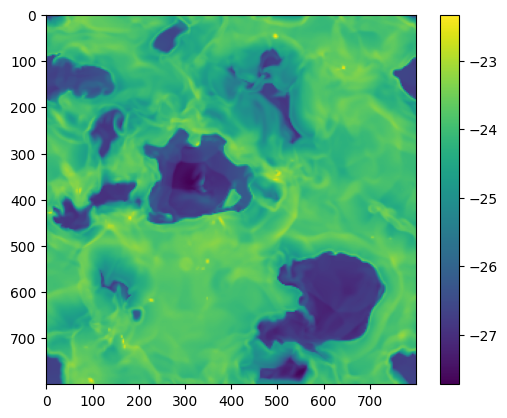

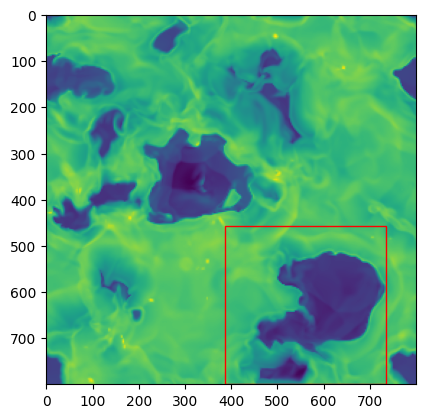

In [70]:
plt.imshow(np.log10(obj["flash", "dens"][:,:,300].T[::-1]))
plt.colorbar()

# Create figure and axes 
fig, ax = plt.subplots(1) 
  
# Display the image 
ax.imshow(np.log10(obj["flash", "dens"][:,:,300].T[::-1])) 
  
# Create a Rectangle patch 
rect = patches.Rectangle((low_x0, low_y0), low_w, low_h, linewidth=1, 
                         edgecolor='r', facecolor="none")
  
# Add the patch to the Axes 
ax.add_patch(rect) 
plt.show() 


# plt.savefig("density.png")

# Import the log file into panda dataframes

In [71]:
import pandas as pd
from glob import glob


# List all .dat files in the current directory
# CV lab
dat_file_root = "/home/joy0921/Desktop/2023S/Dataset/SNfeedback"

# Compute2.idsl
# dat_file_root = "/home/joy0921/Desktop/Dataset/SNfeedback"

dat_files = glob(os.path.join(dat_file_root, "*.dat"))

# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Read and concatenate data from all .dat files
for dat_file in dat_files:
    # Assuming space-separated values in the .dat files
    df = pd.read_csv(dat_file, delim_whitespace=True, header=None,
                     names=['n_SN', 'type', 'n_timestep', 'n_tracer', 'time',
                            'posx', 'posy', 'posz', 'radius', 'mass'])
    
    # Convert the columns to numerical
    df = df.iloc[1:]
    df['n_SN'] = df['n_SN'].map(int)
    df['type'] = df['type'].map(int)
    df['n_timestep'] = df['n_timestep'].map(int)
    df['n_tracer'] = df['n_tracer'].map(int)
    df['time'] = pd.to_numeric(df['time'],errors='coerce')
    df['posx'] = pd.to_numeric(df['posx'],errors='coerce')
    df['posy'] = pd.to_numeric(df['posy'],errors='coerce')
    df['posz'] = pd.to_numeric(df['posz'],errors='coerce')
    df['radius'] = pd.to_numeric(df['radius'],errors='coerce')
    df['mass'] = pd.to_numeric(df['mass'],errors='coerce')
    all_data = pd.concat([all_data, df], ignore_index=True)

all_data.head()


,n_SN,type,n_timestep,n_tracer,time,posx,posy,posz,radius,mass
0,1,2,12,0,2.869811e+12,9.763277e+20,1.530785e+21,-1.072755e+21,1.243486e+20,4.098446e+35
1,2,1,20,0,4.796885e+12,-1.145076e+21,-1.434358e+21,-1.205343e+19,3.511398e+19,9.042147e+35
2,3,2,26,0,5.738623e+12,3.977631e+20,-1.337930e+21,4.700837e+20,4.278450e+19,4.298436e+35
3,4,2,34,0,8.607434e+12,-1.120969e+21,1.482572e+21,-1.084808e+20,3.511398e+19,8.470546e+35
4,5,1,40,0,9.592771e+12,1.434358e+21,-8.557934e+20,2.205777e+21,3.085678e+20,4.513983e+33


In [72]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96771 entries, 0 to 96770
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   n_SN        96771 non-null  int64  
 1   type        96771 non-null  int64  
 2   n_timestep  96771 non-null  int64  
 3   n_tracer    96771 non-null  int64  
 4   time        96771 non-null  float64
 5   posx        96771 non-null  float64
 6   posy        96771 non-null  float64
 7   posz        96771 non-null  float64
 8   radius      96771 non-null  float64
 9   mass        96771 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 7.4 MB


In [73]:
# convert seconds to Megayears
def seconds_to_megayears(seconds):
    return seconds / (1e6 * 365 * 24 * 3600)

# Convert pixel value to pc
def pixel2pc(pixel):
    return (pixel * 10) / 8

def cm2pc(cm):
    return cm * 3.24077929e-19

# filter the DataFrame
def filter_data(df, range_coord):
    return df[(df['posx_pc'] > range_coord[0]) & (df['posx_pc'] < range_coord[0] + range_coord[2]) & (df['posy_pc'] > range_coord[1]) & (df['posy_pc'] < range_coord[1] + range_coord[3]) & (df['posz_pc'] > range_coord[4] & (df['posz_pc'] < range_coord[5]))]


# Convert time to Megayears
all_data['time_Myr'] = seconds_to_megayears(all_data['time'])

# Convert 'pos' from centimeters to parsecs
all_data['posx_pc'] = cm2pc(all_data['posx'])
all_data['posy_pc'] = cm2pc(all_data['posy'])
all_data['posz_pc'] = cm2pc(all_data['posz'])

# Sort the DataFrame by time in ascending order
all_data.sort_values(by='time_Myr', inplace=True)

# convert the cube range to pc
low_x0, low_y0, low_w, low_h, bottom_z, top_z = 386,456, 350, 343, 0, 600
low_x0, low_y0, low_w, low_h = pixel2pc(low_x0) - 500, pixel2pc(low_y0) - 500, pixel2pc(low_w), pixel2pc(low_h)

In [74]:
low_x0, low_y0, low_w, low_h, bottom_z, top_z

(-17.5, 70.0, 437.5, 428.75, 0, 600)

In [75]:
start_yr = 199
end_yr = 200

# Filter data based on specified conditions
filtered_data = filter_data(all_data[(all_data['time_Myr'] >= start_yr) & (all_data['time_Myr'] <= end_yr)], (low_x0, low_y0, low_w, low_h, bottom_z, top_z))
# filtered_data = filter_data(all_data[(all_data['time'] >= start_yr) & (all_data['time'] <= end_yr)], (-50, 50, 500, 500))


# Print the resulting DataFrame
print(filtered_data)

       n_SN  type  n_timestep  n_tracer          time          posx  \
8255   6489     1       50353      1995  6.287407e+15  4.158433e+20   
89087  6493     1       50361         0  6.287407e+15  4.158433e+20   
34503  6489     1       50353      1995  6.287407e+15  4.158433e+20   
46471  6489     1       50353      1995  6.287407e+15  4.158433e+20   
90850  6489     1       50353      1995  6.287407e+15  4.158433e+20   
81121  6493     1       50361         0  6.287407e+15  4.158433e+20   
6492   6493     1       50361         0  6.287407e+15  4.158433e+20   
73043  6489     1       50353      1995  6.287407e+15  4.158433e+20   
44708  6493     1       50361         0  6.287407e+15  4.158433e+20   
71280  6493     1       50361         0  6.287407e+15  4.158433e+20   
32740  6493     1       50361         0  6.287407e+15  4.158433e+20   
58833  6493     1       50361         0  6.287407e+15  4.158433e+20   
20617  6493     1       50361         0  6.287407e+15  4.158433e+20   
8261  

In [76]:
filtered_data.drop_duplicates(subset=['posx_pc', 'n_tracer', 'n_SN'], keep='last')
filtered_data

,n_SN,type,n_timestep,n_tracer,time,posx,posy,posz,radius,mass,time_Myr,posx_pc,posy_pc,posz_pc
8255,6489,1,50353,1995,6.287407e+15,4.158433e+20,1.343957e+21,2.260018e+21,3.085678e+20,1.779100e+35,199.372362,134.765626,435.546866,732.421888
89087,6493,1,50361,0,6.287407e+15,4.158433e+20,1.343957e+21,2.260018e+21,3.085678e+20,2.626707e+35,199.372362,134.765626,435.546866,732.421888
34503,6489,1,50353,1995,6.287407e+15,4.158433e+20,1.343957e+21,2.260018e+21,3.085678e+20,1.779100e+35,199.372362,134.765626,435.546866,732.421888
46471,6489,1,50353,1995,6.287407e+15,4.158433e+20,1.343957e+21,2.260018e+21,3.085678e+20,1.779100e+35,199.372362,134.765626,435.546866,732.421888
90850,6489,1,50353,1995,6.287407e+15,4.158433e+20,1.343957e+21,2.260018e+21,3.085678e+20,1.779100e+35,199.372362,134.765626,435.546866,732.421888
81121,6493,1,50361,0,6.287407e+15,4.158433e+20,1.343957e+21,2.260018e+21,3.085678e+20,2.626707e+35,199.372362,134.765626,435.546866,732.421888
6492,6493,1,50361,0,6.287407e+15,4.158433e+20,1.343957e+21,2.260018e+21,3.085678e+20,2.626707e+35,199.372362,134.765626,435.546866,732.421888
73043,6489,1,50353,1995,6.287407e+15,4.158433e+20,1.343957e+21,2.260018e+21,3.085678e+20,1.779100e+35,199.372362,134.765626,435.546866,732.421888
44708,6493,1,50361,0,6.287407e+15,4.158433e+20,1.343957e+21,2.260018e+21,3.085678e+20,2.626707e+35,199.372362,134.765626,435.546866,732.421888
71280,6493,1,50361,0,6.287407e+15,4.158433e+20,1.343957e+21,2.260018e+21,3.085678e+20,2.626707e+35,199.372362,134.765626,435.546866,732.421888


In [77]:
filtered_data.drop(columns=['posx', 'posy', 'posz', 'time'], inplace=True)
filtered_data.to_csv('SNfeedback_185_200.txt', sep='\t', index=False, encoding='utf-8')

In [64]:
z = cm2pc(-6.17135516e+22)
z
x = cm2pc(-1.54283879e+21)
x

-499.999999844066